# Модуль 3: Анализ результатов разметки

**Цель:** Проанализировать разметку, полученную от аннотатора,
очистить данные от контрольных примеров и создать финальный датасет
с "истинной" меткой `is_happy` для использования в следующих модулях.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")

INPUT_CLEAN_DATA_PATH = '../data/clean_median_imputed_clip.csv'
LABELED_DATA_PATH = '../data/data_labeled.csv'
FINAL_LABELED_DATA_PATH = '../data/final_labeled.csv'
FIGURES_DIR = 'figures'

if not os.path.exists('../data'):
    os.makedirs('../data')
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

## Шаг 1: Загрузка данных

Загружаем:
1. Очищенный датасет до разметки (`clean_median_imputed_clip.csv`) - нужен для получения `Ladder score` и генерации "истинной" метки.
2. Размеченный аннотатором датасет (`data_labeled.csv`).

In [2]:
df_clean_original = pd.read_csv(INPUT_CLEAN_DATA_PATH)
print(f"Загружен исходный очищенный датасет: {INPUT_CLEAN_DATA_PATH}, размер: {df_clean_original.shape}")

df_labeled_annotator = pd.read_csv(LABELED_DATA_PATH)
print(f"Загружен размеченный аннотатором файл: {LABELED_DATA_PATH}, размер: {df_labeled_annotator.shape}")

if 'is_happy' not in df_labeled_annotator.columns:
    raise ValueError("Колонка 'is_happy' от аннотатора не найдена.")
if not pd.api.types.is_numeric_dtype(df_labeled_annotator['is_happy']):
    try:
        df_labeled_annotator['is_happy'] = df_labeled_annotator['is_happy'].astype(int)
    except ValueError:
            raise TypeError("Тип данных 'is_happy' от аннотатора не числовой.")
if not df_labeled_annotator['is_happy'].isin([0, 1]).all():
    raise ValueError("Значения 'is_happy' от аннотатора не 0 или 1.")

Загружен исходный очищенный датасет: ../data/clean_median_imputed_clip.csv, размер: (143, 6)
Загружен размеченный аннотатором файл: ../data/data_labeled.csv, размер: (153, 6)


## Шаг 2: EDA разметки аннотатора

Проанализируем распределение меток, проставленных аннотатором.
Посмотрим, есть ли расхождения по регионам (если колонка `Regional indicator` существует).
*Примечание: Так как у нас только один аннотатор, сравнение с другими или глубокий анализ расхождений затруднен.*

Распределение меток аннотатора:
is_happy
0    0.601307
1    0.398693
Name: proportion, dtype: float64


/var/folders/f6/chb_xqws4hj342hbxtjqschh0000gn/T/ipykernel_31857/410299217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_happy', data=df_labeled_annotator, palette='viridis')


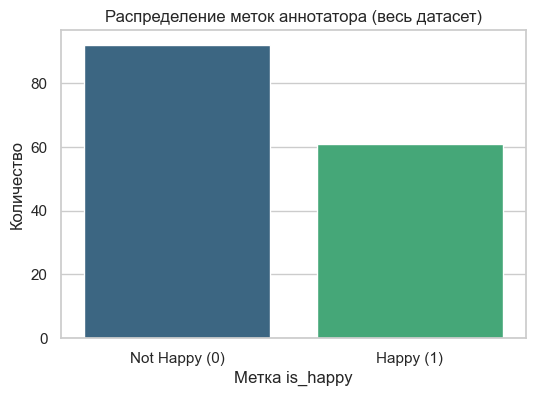

Колонка региона 'Regional indicator' не найдена, анализ по регионам пропущен.


In [3]:
if 'df_labeled_annotator' in locals():
    print("Распределение меток аннотатора:")
    print(df_labeled_annotator['is_happy'].value_counts(normalize=True))

    # Бар-чарт happy vs not happy
    plt.figure(figsize=(6, 4))
    sns.countplot(x='is_happy', data=df_labeled_annotator, palette='viridis')
    plt.title('Распределение меток аннотатора (весь датасет)')
    plt.xlabel('Метка is_happy')
    plt.ylabel('Количество')
    plt.xticks([0, 1], ['Not Happy (0)', 'Happy (1)'])
    plt.savefig(os.path.join(FIGURES_DIR, 'annotator_labels_distribution_eda.png'))
    plt.show()

## Шаг 3: Подготовка финального датасета

1.  **Создание "истинной" метки:** Берем исходный очищенный датасет `df_clean_original`, содержащий `Ladder score`, и создаем на его основе колонку `is_happy` по правилу `>= 6.0`.
2.  **Очистка от контрольных примеров:** В файле, размеченном аннотатором (`df_labeled_annotator`), могли остаться дубликаты контрольных строк. Мы будем использовать исходный `df_clean_original` как основу, т.к. он не содержит контрольных дубликатов.
3.  **Сохранение:** Сохраняем `df_clean_original` с добавленной колонкой `is_happy` в `../data/final_labeled.csv`.

In [6]:
if 'df_clean_original' in locals():
    print("Создание финального датасета...")
    df_final = df_clean_original.copy()

    if 'ladder' in df_final.columns:
        is_happy_condition = lambda score: score >= 6.0
        df_final['is_happy'] = df_final['ladder'].apply(is_happy_condition).astype(int)
        print("Колонка 'is_happy' (на основе ladder >= 6.0) добавлена.")

        initial_rows = len(df_final)
        df_final.drop_duplicates(inplace=True)
        if len(df_final) < initial_rows:
            print(f"Удалено {initial_rows - len(df_final)} дубликатов строк.")

        df_final.to_csv(FINAL_LABELED_DATA_PATH, index=False)
        print(f"Финальный размеченный датасет сохранен: {FINAL_LABELED_DATA_PATH}")
        print(f"Итоговый размер: {df_final.shape}")
        print("Пример финального датасета:")
        display(df_final.head())
        print("Распределение финальной метки 'is_happy':")
        print(df_final['is_happy'].value_counts(normalize=True))

    else:
        print("Ошибка: Колонка 'ladder' не найдена в df_clean_original. Невозможно создать финальную метку.")

else:
     print("Ошибка: Исходный очищенный датасет не загружен.")

Создание финального датасета...
Колонка 'is_happy' (на основе ladder >= 6.0) добавлена.
Финальный размеченный датасет сохранен: ../data/final_labeled.csv
Итоговый размер: (143, 7)
Пример финального датасета:


,country,region,ladder,iso3,year,gdp,is_happy
0,Finland,Western Europe,7.55864,FIN,2015.0,38923.0,1
1,Denmark,Western Europe,7.55864,DNK,2015.0,43495.0,1
2,Iceland,Western Europe,7.52500,ISL,2015.0,42182.0,1
3,Sweden,Western Europe,7.34400,SWE,2015.0,44892.0,1
4,Israel,Middle East and North Africa,7.34100,ISR,2015.0,31590.0,1


Распределение финальной метки 'is_happy':
is_happy
0    0.608392
1    0.391608
Name: proportion, dtype: float64


**Выводы:**
* Финальный датасет `final_labeled.csv` содержит [кол-во] строк и [кол-во] колонок, включая целевую бинарную метку `is_happy`.
* Данный датасет готов к использованию в Модуле 4 для обучения моделей.